In [ ]:
import environ
import sys
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# Load environment variables
env = environ.Env()
environ.Env.read_env()

# Paths from environment variables
paths = {
    "model_save_dir": env('model_save_dir'),  #* Folder where we save the trained model
    "new_folders_path": env('new_folders_path'),
    "data_set_brain_MRI_segmentation": env('data_set_brain_MRI_segmentation'),  #* Folder where we save the dataset of: https://www.kaggle.com/datasets/mateuszbuda/lgg-mri-segmentation
}

# Append paths to system path
for path in paths:
    sys.path.append(path)

# Device configuration
device = "cuda" if torch.cuda.is_available() else "cpu"
print("device =", device)

device = cuda


In [ ]:
from dataset_preparation import preparation_brain_MRI_set

preparation_brain_MRI_set(
    path_data_set = paths['data_set_brain_MRI_segmentation'], 
    new_folders_path = paths['new_folders_path'], 
)

In [3]:
image_Height   = 252
image_Width    = 252

outPutimage_Height = 68
outPutimage_Width  = 68

image_Channels = 3
batch_size     = 16

In [4]:
from data_set import DataSetImgToImg
from torch.utils.data import DataLoader
from torch.utils.data import DataLoader, RandomSampler


input_resize = transforms.Compose([
    transforms.ToPILImage(),  # Convert to PIL Image
    transforms.Resize((image_Height, image_Width)),  # Resize the image
    transforms.Grayscale(num_output_channels = image_Channels),  # Convert to black and white
    transforms.ToTensor(),  # Convert to tensor
])


out_put_resize = transforms.Compose([
                        #* Compose = compoues a list of function
                        transforms.ToPILImage(),
                        transforms.Resize((outPutimage_Height, outPutimage_Width)),
                        # transforms.RandomRotation(degrees=5),  # Randomly rotate the image by up to 5 degrees
                                        
                        #* ToPILImage = cahnge the data type from PyTorch tensor or a NumPy ndarray to : A PIL (Python Imaging Library)
                        # transforms.RandomVerticalFlip(),
                        # transforms.RandomHorizontalFlip(),
                        # transforms.RandomRotation(degrees=15),  
                        transforms.ToTensor(), 
                        #* change the data type from Numpy or PIL to tensor
                        ])

root_Data            = [paths['new_folders_path'] + "/train/img", paths['new_folders_path'] + "/train/mask"]
root_Data_Validation = [paths['new_folders_path'] + "/validation/img", paths['new_folders_path'] + "/validation/mask"]

myDataSet            = DataSetImgToImg(root_Data, trans_for_in_img = input_resize, trans_for_out_img = out_put_resize, test = False, data_size = 100)
myDataSetValidation  = DataSetImgToImg(root_Data_Validation, trans_for_in_img = input_resize, trans_for_out_img = out_put_resize, test = False, data_size = 100)


Size data set lower definition 3929
Size data set lower definition 785


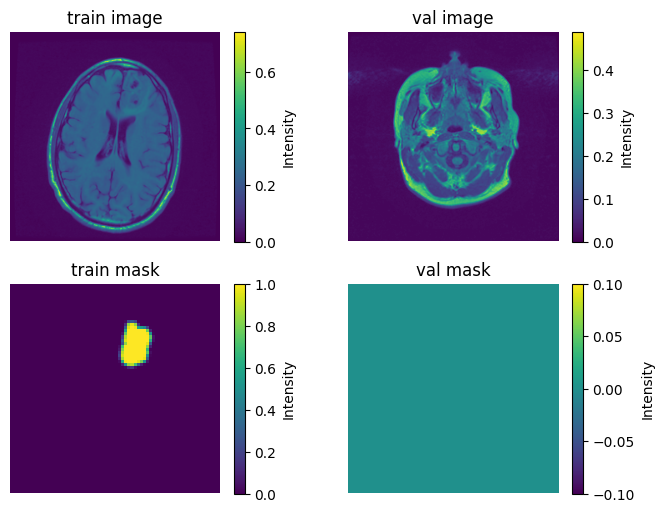

In [5]:
from test_tools import plot_img_tensor
import matplotlib.pyplot as plt
import random


index = random.randint(0, len(myDataSetValidation) - 1)
fig, (plt1, plt2) = plt.subplots(2, 2, figsize=(8, 6))
plot_img_tensor(myDataSet.__getitem__(index=index)[0], plot_channels = [0], title = "train image", localplt = (fig, plt1[0]))
plot_img_tensor(myDataSet.__getitem__(index=index)[1], plot_channels = [0], title = "train mask" , localplt = (fig, plt2[0]))
plot_img_tensor(myDataSetValidation.__getitem__(index=index)[0], plot_channels = [0], title = "val image", localplt = (fig, plt1[1]))
plot_img_tensor(myDataSetValidation.__getitem__(index=index)[1], plot_channels = [0], title = "val mask" , localplt = (fig, plt2[1]))
plt.show()

In [6]:
import importlib
from model import ModelUNet, modeluNet

my_model_u_net = modeluNet(in_channels = 3)
my_model_u_net.to(device = device)
print(my_model_u_net)

modeluNet(
  (downsampling1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): SiLU()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (4): SiLU()
  )
  (downsampling2): Sequential(
    (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (1): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
      (1): SiLU()
      (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
      (4): SiLU()
    )
  )
  (downsampling3): Sequential(
    (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (1): Sequential(
      (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
      (1): SiLU()
      (2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3

In [7]:
import importlib
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from fit_functions import FiterUNet


trainerModel = FiterUNet(
        my_model_u_net, 
        myDataSet, 
        device      = device,
        batch_size  = batch_size,
        data_set_val = myDataSetValidation,
        model_save_dir =  paths['model_save_dir'],
)

#TODO add gradiente decent with adjustable step size
# opt_model = optim.Adam(my_model_u_net.parameters(), lr = 0.0001)

opt_model = torch.optim.SGD(
        my_model_u_net.parameters(),
        lr = 0.001,
        momentum=0.95,
        weight_decay=1e-4,
)

criterion  = torch.nn.CrossEntropyLoss()

In [11]:
trainerModel.TrainModel(opt_model  = opt_model,
                        criterion  = criterion,
                        num_epochs = 10,
                        get_val_MAE= True)

  0%|          | 0/246 [00:00<?, ?it/s]C:\Users\malekir1\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
Epoch 1/10 process: 99: 100%|██████████| 246/246 [01:38<00:00,  2.49it/s, modelLoss=0.456]


Epoch completed, TRAIN MAE 0.5503
Epoch completed, VAL MAE: 0.463269


Epoch 2/10 process: 99: 100%|██████████| 246/246 [01:07<00:00,  3.65it/s, modelLoss=0.376]


Epoch completed, TRAIN MAE 0.4100
Epoch completed, VAL MAE: 0.386847


Epoch 3/10 process: 99: 100%|██████████| 246/246 [01:07<00:00,  3.65it/s, modelLoss=0.353]


Epoch completed, TRAIN MAE 0.3642
Epoch completed, VAL MAE: 0.359937


Epoch 4/10 process: 99: 100%|██████████| 246/246 [01:07<00:00,  3.66it/s, modelLoss=0.342]


Epoch completed, TRAIN MAE 0.3462
Epoch completed, VAL MAE: 0.347686


Epoch 5/10 process: 99: 100%|██████████| 246/246 [01:07<00:00,  3.65it/s, modelLoss=0.34] 


Epoch completed, TRAIN MAE 0.3375
Epoch completed, VAL MAE: 0.341668


Epoch 6/10 process: 99: 100%|██████████| 246/246 [01:07<00:00,  3.64it/s, modelLoss=0.33] 


Epoch completed, TRAIN MAE 0.3328
Epoch completed, VAL MAE: 0.337375


Epoch 7/10 process: 99: 100%|██████████| 246/246 [01:07<00:00,  3.65it/s, modelLoss=0.335]


Epoch completed, TRAIN MAE 0.3295
Epoch completed, VAL MAE: 0.335207


Epoch 8/10 process: 99: 100%|██████████| 246/246 [01:07<00:00,  3.64it/s, modelLoss=0.323]


Epoch completed, TRAIN MAE 0.3275
Epoch completed, VAL MAE: 0.335121


Epoch 9/10 process: 99: 100%|██████████| 246/246 [01:07<00:00,  3.64it/s, modelLoss=0.326]


Epoch completed, TRAIN MAE 0.3260
Epoch completed, VAL MAE: 0.331993


Epoch 10/10 process: 99: 100%|██████████| 246/246 [01:07<00:00,  3.66it/s, modelLoss=0.325]


Epoch completed, TRAIN MAE 0.3250
Epoch completed, VAL MAE: 0.331195


In [12]:

opt_model.param_groups[0]["lr"] = 0.00001
trainerModel.TrainModel(opt_model  = opt_model,
                        criterion  = criterion,
                        num_epochs = 5,
                        get_val_MAE= True)

Epoch 1/5 process: 99: 100%|██████████| 246/246 [01:07<00:00,  3.67it/s, modelLoss=0.324]


Epoch completed, TRAIN MAE 0.3244
Epoch completed, VAL MAE: 0.331271


Epoch 2/5 process: 99: 100%|██████████| 246/246 [01:07<00:00,  3.66it/s, modelLoss=0.326]


Epoch completed, TRAIN MAE 0.3244
Epoch completed, VAL MAE: 0.330724


Epoch 3/5 process: 99: 100%|██████████| 246/246 [01:07<00:00,  3.67it/s, modelLoss=0.326]


Epoch completed, TRAIN MAE 0.3244
Epoch completed, VAL MAE: 0.331187


Epoch 4/5 process: 99: 100%|██████████| 246/246 [01:07<00:00,  3.65it/s, modelLoss=0.325]


Epoch completed, TRAIN MAE 0.3243
Epoch completed, VAL MAE: 0.331042


Epoch 5/5 process: 99: 100%|██████████| 246/246 [01:07<00:00,  3.63it/s, modelLoss=0.329]


Epoch completed, TRAIN MAE 0.3244
Epoch completed, VAL MAE: 0.330812


In [ ]:
trainerModel.ToggleTrainingLayers(["downsampling"], enable = False)
opt_model.param_groups[0]["lr"] = 0.000001

trainerModel.TrainModel(opt_model  = opt_model,
                        criterion  = criterion,
                        num_epochs = 15,
                        get_val_MAE= True)

downsampling1.0.weight : False
downsampling1.0.bias : False
downsampling1.2.weight : False
downsampling1.2.bias : False
downsampling1.3.weight : False
downsampling1.3.bias : False
downsampling2.1.0.weight : False
downsampling2.1.0.bias : False
downsampling2.1.2.weight : False
downsampling2.1.2.bias : False
downsampling2.1.3.weight : False
downsampling2.1.3.bias : False
downsampling3.1.0.weight : False
downsampling3.1.0.bias : False
downsampling3.1.2.weight : False
downsampling3.1.2.bias : False
downsampling3.1.3.weight : False
downsampling3.1.3.bias : False
downsampling4.1.0.weight : False
downsampling4.1.0.bias : False
downsampling4.1.2.weight : False
downsampling4.1.2.bias : False
downsampling4.1.3.weight : False
downsampling4.1.3.bias : False
center_block.1.0.weight : True
center_block.1.0.bias : True
center_block.1.2.weight : True
center_block.1.2.bias : True
center_block.1.3.weight : True
center_block.1.3.bias : True
center_block.2.0.weight : True
center_block.2.0.bias : True
cent

Epoch 1/10 process: 99: 100%|██████████| 246/246 [00:39<00:00,  6.22it/s, modelLoss=0.323]


Epoch completed, TRAIN MAE 0.3244
Epoch completed, VAL MAE: 0.331005


Epoch 2/10 process: 99: 100%|██████████| 246/246 [00:39<00:00,  6.26it/s, modelLoss=0.32] 


Epoch completed, TRAIN MAE 0.3243
Epoch completed, VAL MAE: 0.331050


Epoch 3/10 process: 99: 100%|██████████| 246/246 [00:39<00:00,  6.25it/s, modelLoss=0.324]


Epoch completed, TRAIN MAE 0.3244
Epoch completed, VAL MAE: 0.330994


Epoch 4/10 process: 99: 100%|██████████| 246/246 [00:39<00:00,  6.25it/s, modelLoss=0.326]


Epoch completed, TRAIN MAE 0.3243
Epoch completed, VAL MAE: 0.330793


Epoch 5/10 process: 99: 100%|██████████| 246/246 [00:39<00:00,  6.24it/s, modelLoss=0.321]


Epoch completed, TRAIN MAE 0.3243
Epoch completed, VAL MAE: 0.330960


Epoch 6/10 process: 99: 100%|██████████| 246/246 [00:39<00:00,  6.24it/s, modelLoss=0.327]


Epoch completed, TRAIN MAE 0.3243
Epoch completed, VAL MAE: 0.331130


Epoch 7/10 process: 99: 100%|██████████| 246/246 [00:39<00:00,  6.22it/s, modelLoss=0.326]


Epoch completed, TRAIN MAE 0.3244
Epoch completed, VAL MAE: 0.330749


Epoch 8/10 process: 99: 100%|██████████| 246/246 [00:39<00:00,  6.23it/s, modelLoss=0.324]


Epoch completed, TRAIN MAE 0.3244
Epoch completed, VAL MAE: 0.331394


Epoch 9/10 process: 99: 100%|██████████| 246/246 [00:39<00:00,  6.24it/s, modelLoss=0.332]


Epoch completed, TRAIN MAE 0.3245
Epoch completed, VAL MAE: 0.330967


Epoch 10/10 process: 99: 100%|██████████| 246/246 [00:39<00:00,  6.22it/s, modelLoss=0.323]


Epoch completed, TRAIN MAE 0.3244
Epoch completed, VAL MAE: 0.330965


In [23]:
index = 17
img_input, img_out_put = trainerModel.GetDataBatch(index)
img_input    = img_input.to(device)
img_out_put   = img_out_put.to(device, torch.long)
modelOutPut = my_model_u_net(img_input)


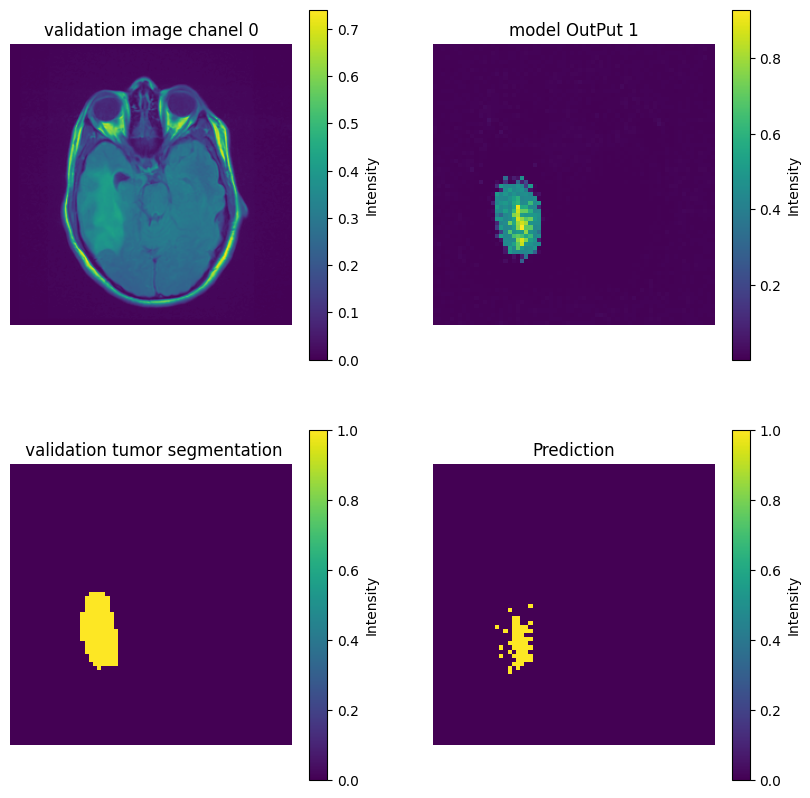

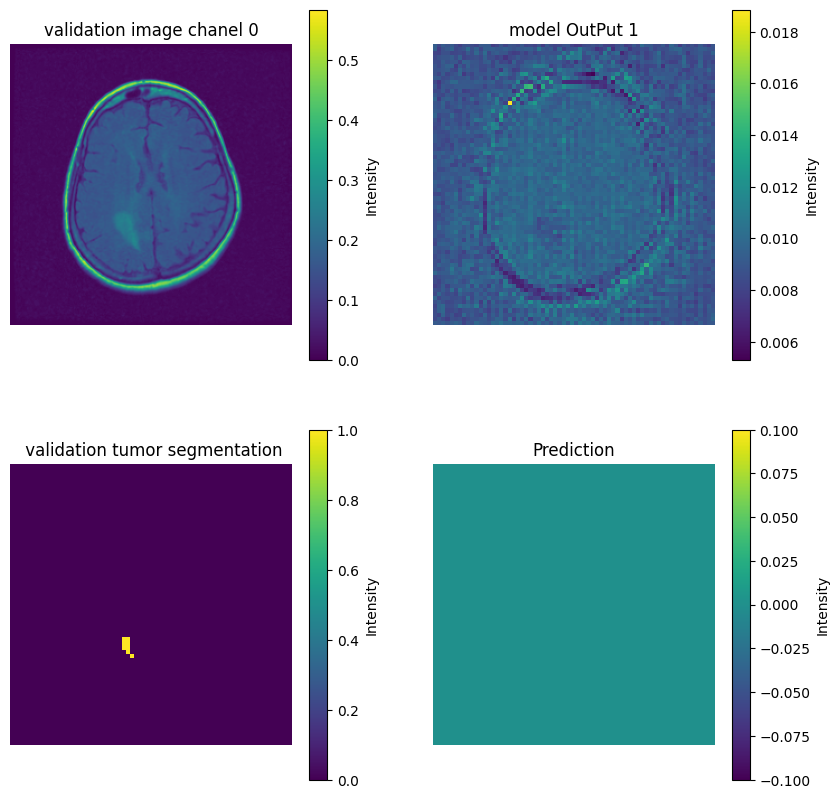

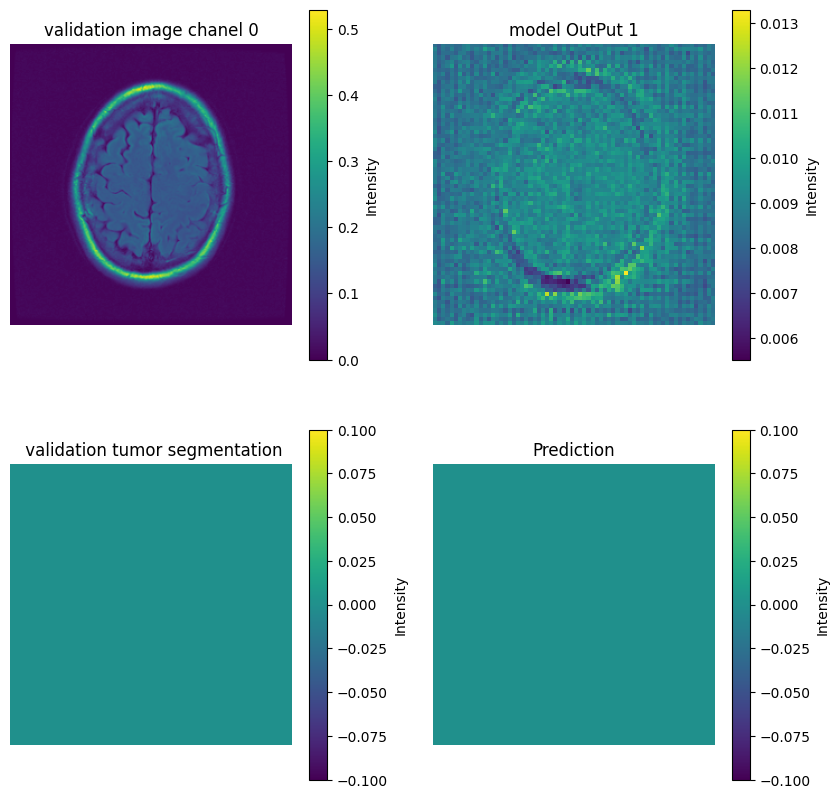

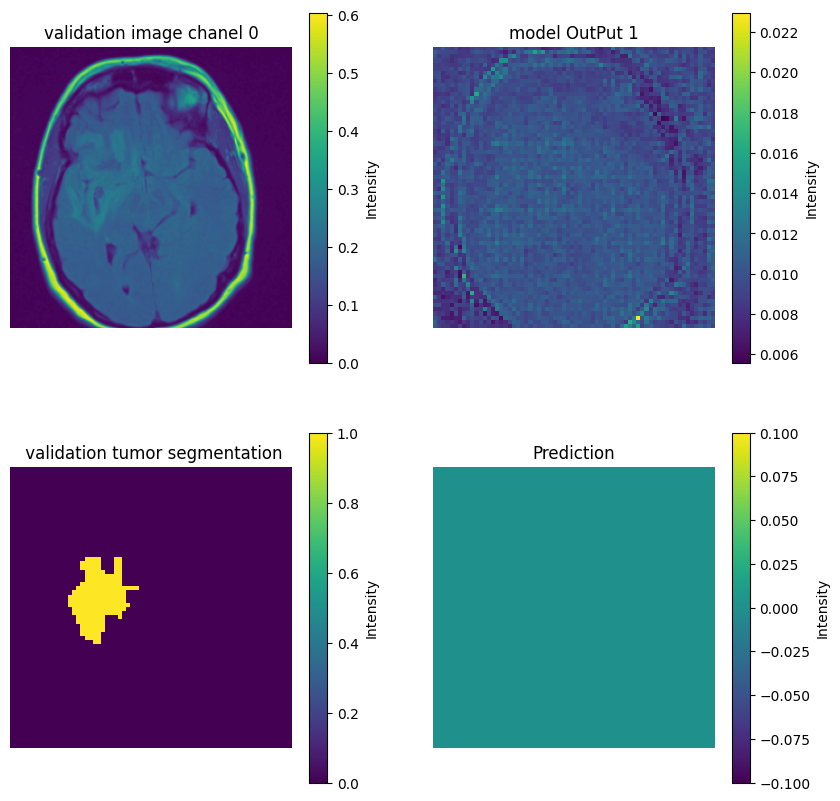

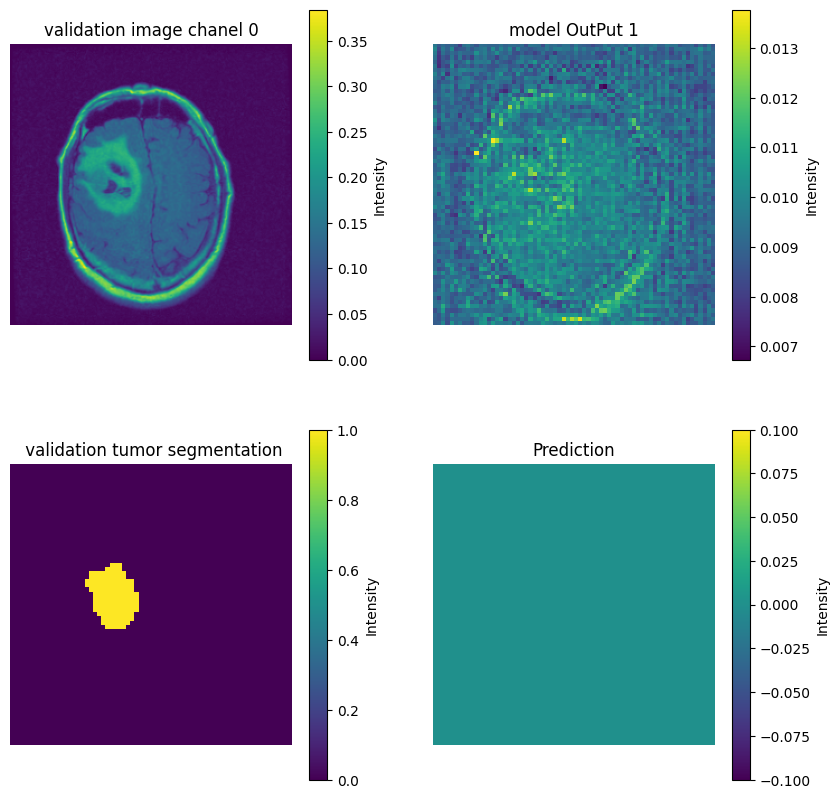

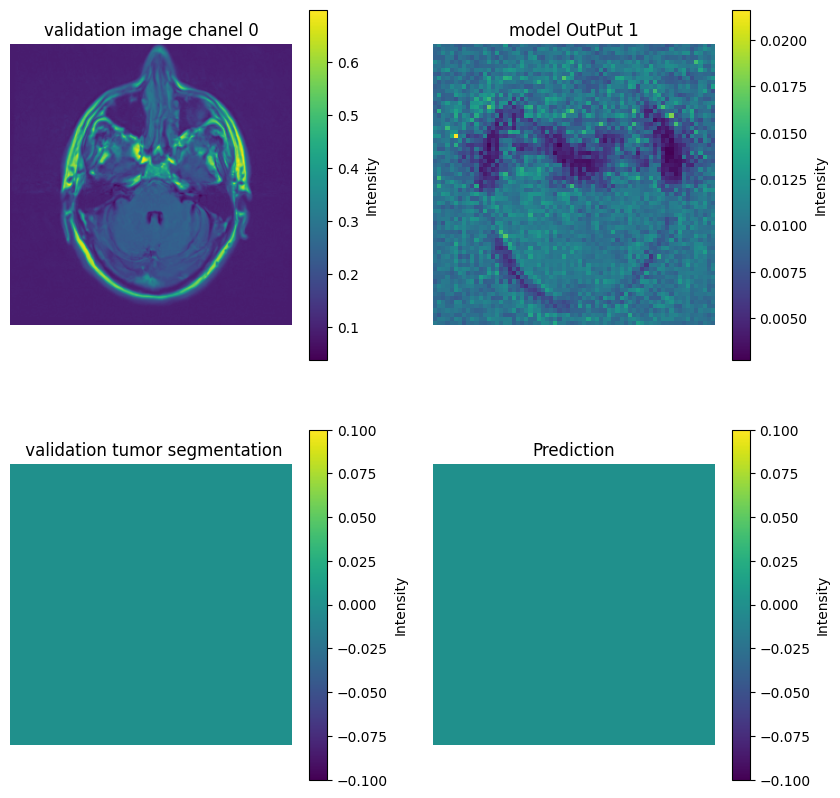

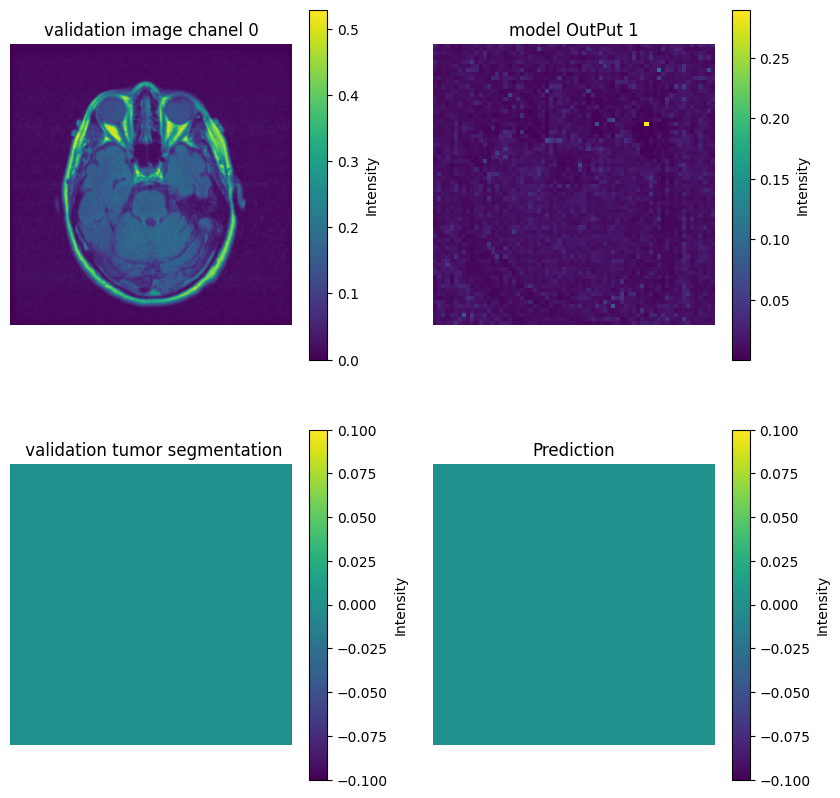

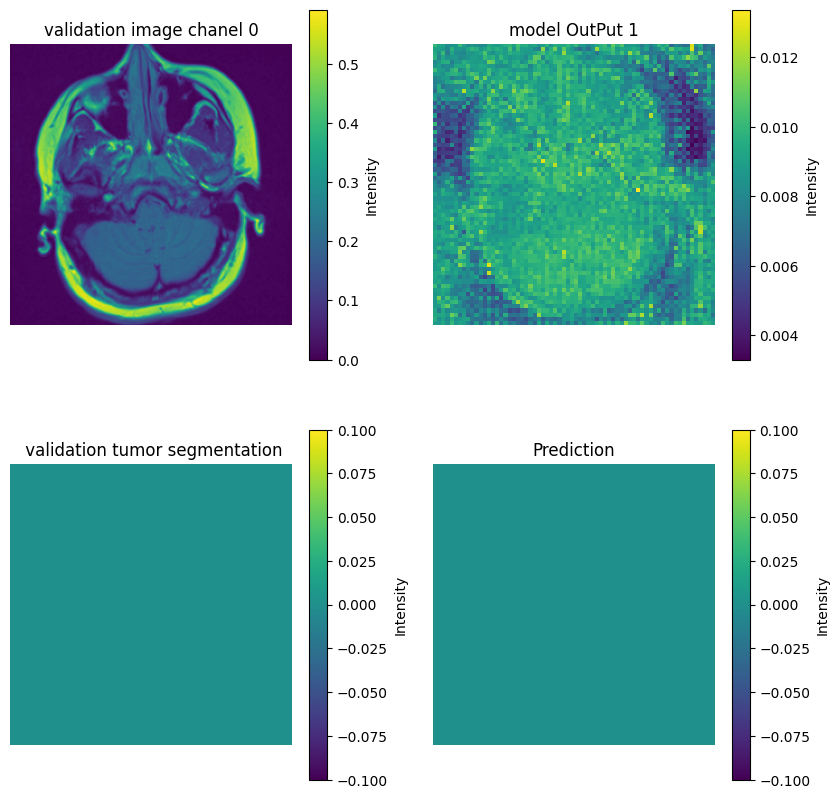

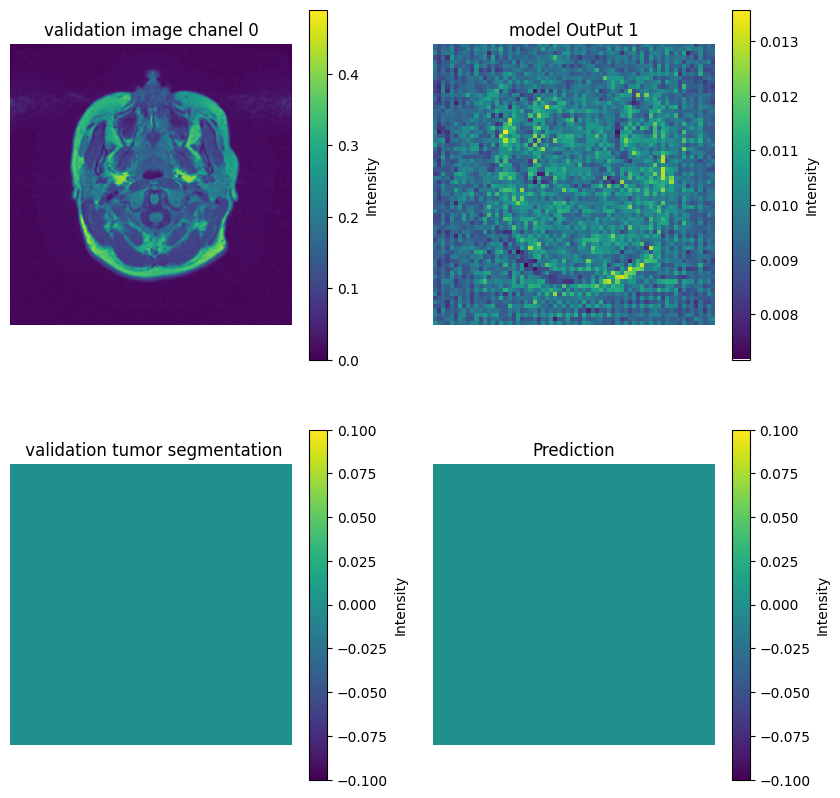

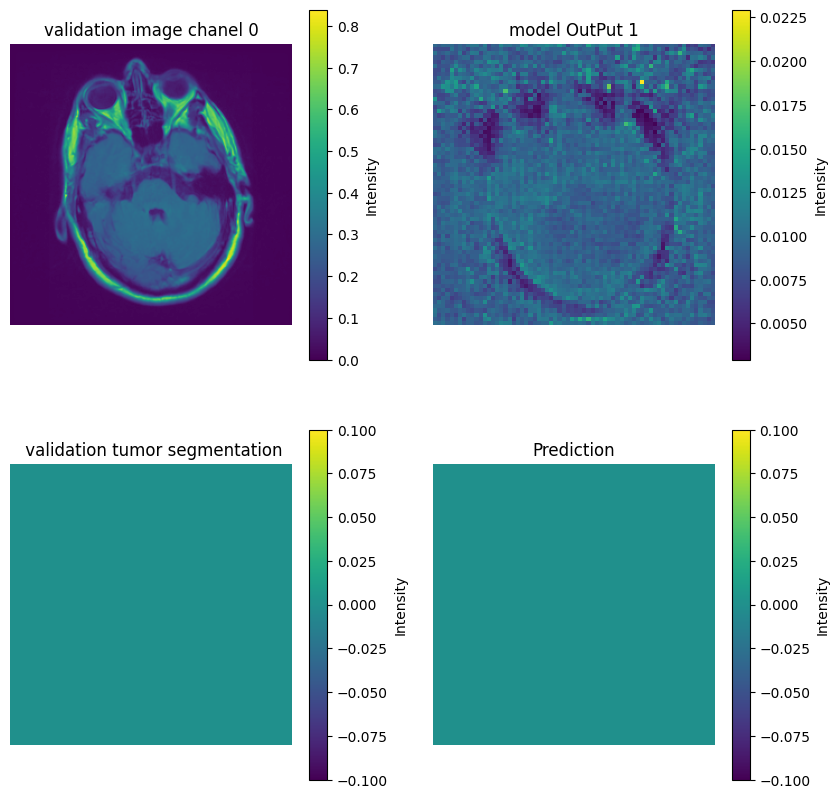

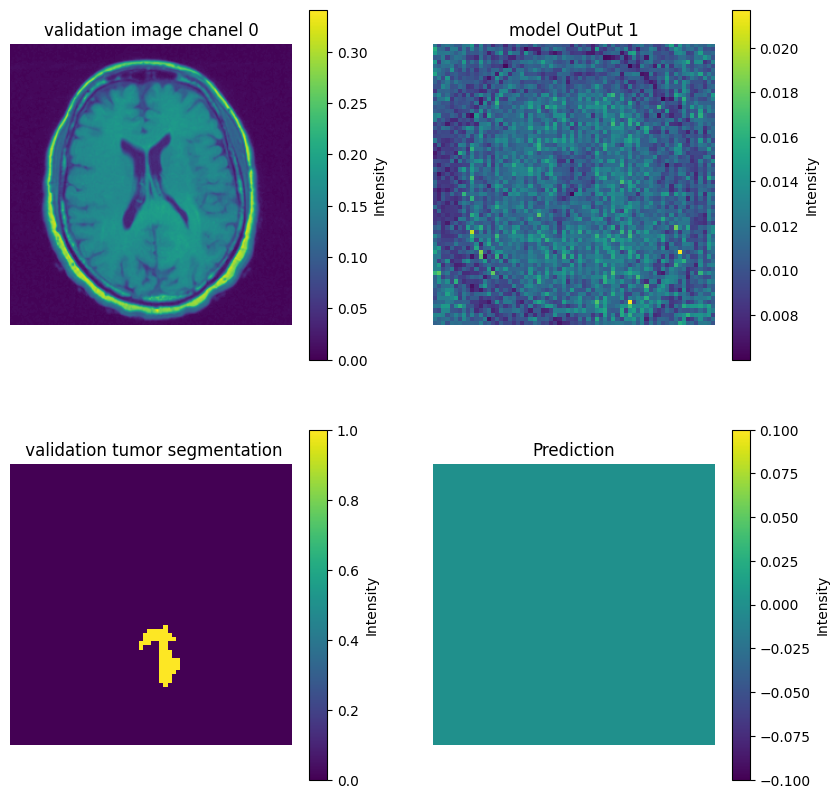

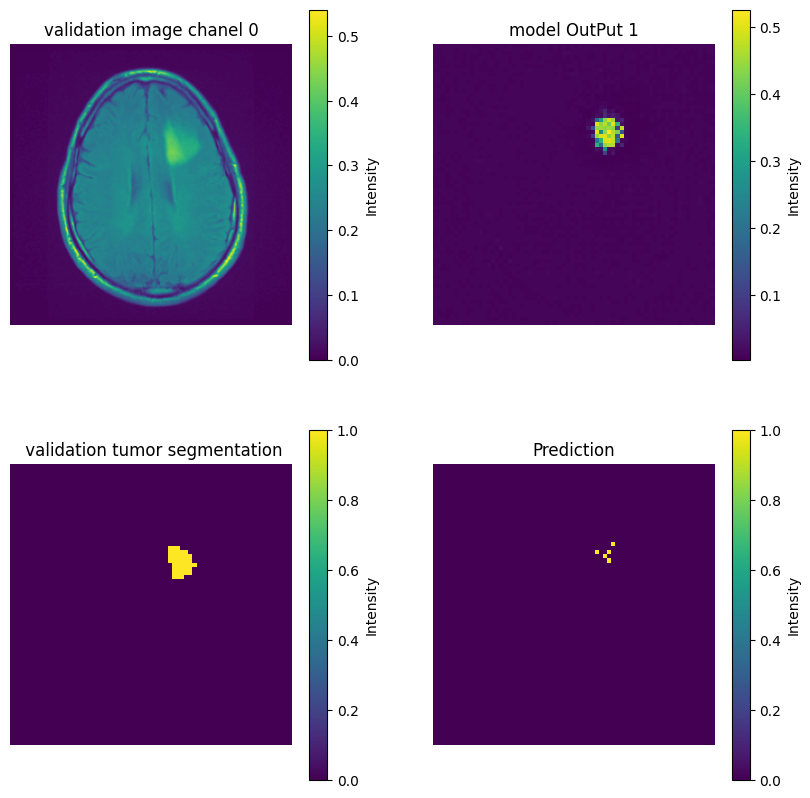

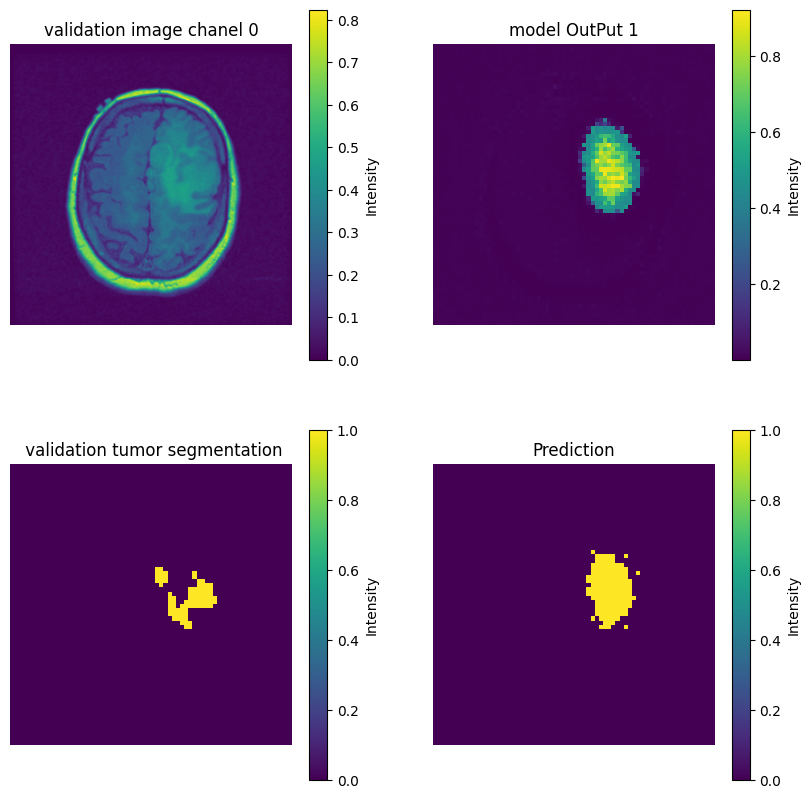

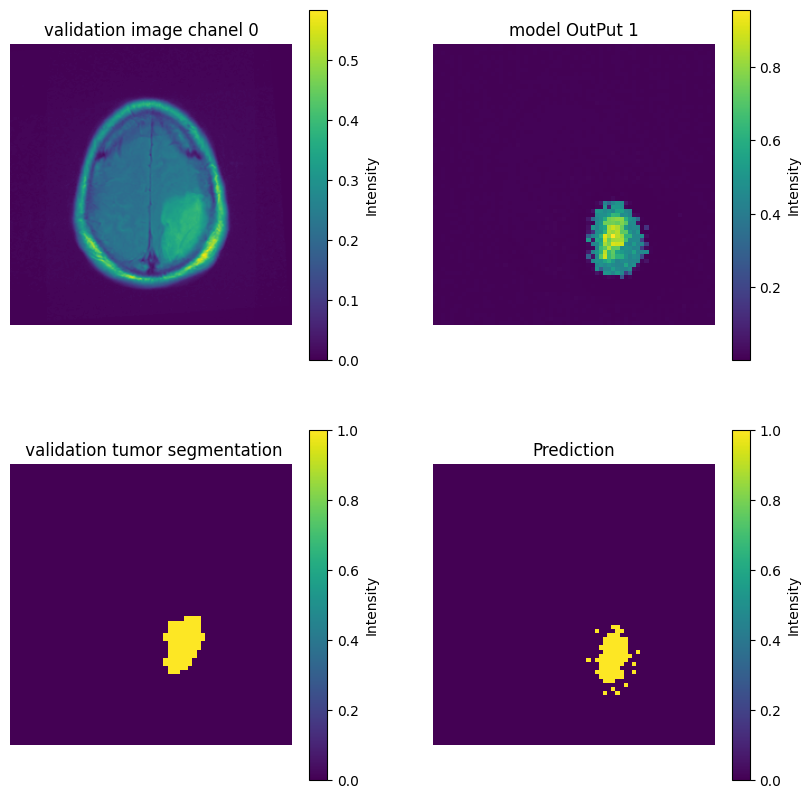

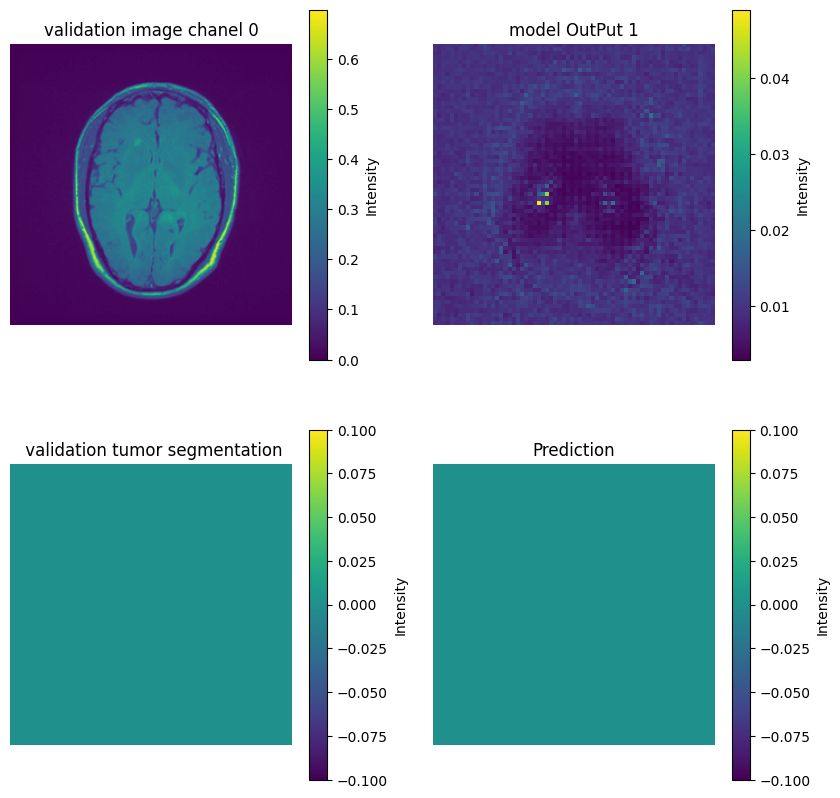

In [24]:

for i in range(15):
    index = 1
    imgInput, imgOutPut = trainerModel.GetDataBatch(index)    
    imgInput    = imgInput.to(device)
    imgOutPut   = imgOutPut.to(device, torch.long)
    modelOutPut = my_model_u_net(imgInput)
    prediction = torch.argmax(modelOutPut[i], dim = 0)
    prediction = prediction.unsqueeze(0)

    fig, (plt1, plt2) = plt.subplots(2, 2, figsize=(10, 10))
    plot_img_tensor(imgInput[i], [0], title = "validation image chanel 0", localplt = (fig, plt1[0]))
    plot_img_tensor(imgOutPut[i], [0], title = " validation tumor segmentation", localplt = (fig, plt2[0]))
    plot_img_tensor(modelOutPut[i], [1], title = "model OutPut 1", localplt = (fig, plt1[1]))
    plot_img_tensor(prediction, [0], title = "Prediction", localplt = (fig, plt2[1]))
    plt.show()


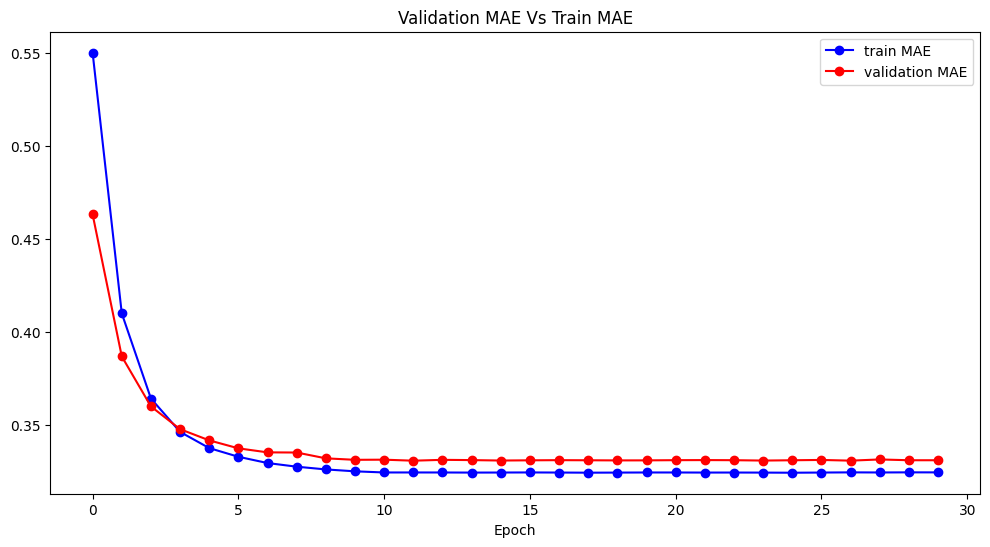

In [21]:
trainerModel.PrintHistorial()

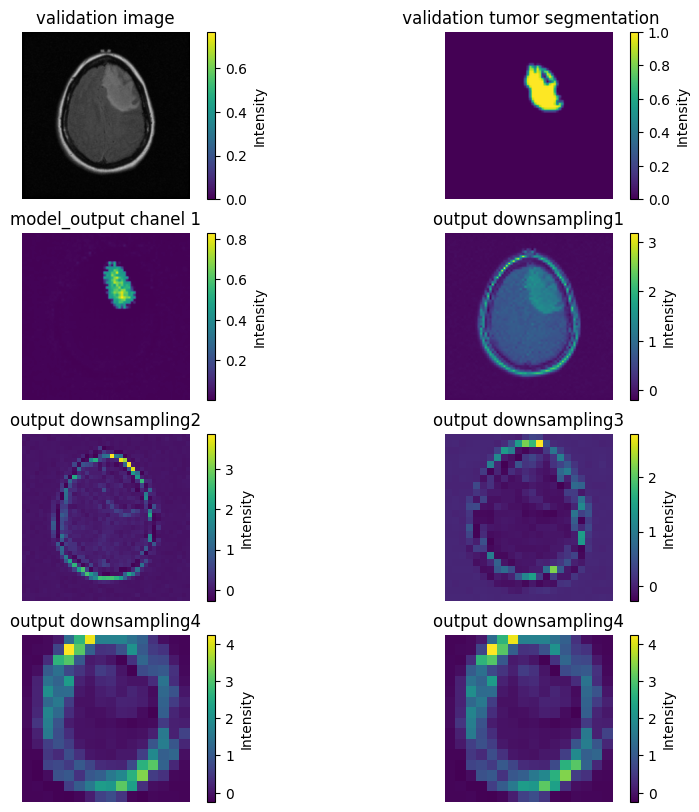

In [34]:
img_input, img_output = trainerModel.GetDataBatch()
img_input, img_output = img_input.to(device), img_output.to(device) 
model_output = my_model_u_net.OutPutsCopys(img_input)

fig, (plt1, plt2, plt3, plt4) = plt.subplots(4, 2, figsize=(10, 10))
plot_img_tensor(   img_input[0], [0, 1, 2], title = "validation image", localplt = (fig, plt1[0]))
plot_img_tensor(  img_output[0], [0], title = " validation tumor segmentation", localplt = (fig, plt1[1]))

plot_img_tensor(model_output[0][0], [1], title = "model_output chanel 1", localplt = (fig, plt2[0]))
plot_img_tensor(model_output[1][0], [0], title = "output downsampling1", localplt = (fig, plt2[1]))
plot_img_tensor(model_output[2][0], [0], title = "output downsampling2", localplt = (fig, plt3[0]))
plot_img_tensor(model_output[3][0], [0], title = "output downsampling3", localplt = (fig, plt3[1]))
plot_img_tensor(model_output[4][0], [0], title = "output downsampling4", localplt = (fig, plt4[0]))
plot_img_tensor(model_output[4][0], [0], title = "output downsampling4", localplt = (fig, plt4[1]))

plt.show()
